## Timing our algorithms

In [43]:
import time, random
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import sys

In [44]:
import parsers, jannesnotes, stinesnotes

In [45]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_one_fasta(n):
    name = f"test_files/n_{n}.fa"
    f = open(name, "w")
    
    f.write('>Seq' + str(1) + '\n' + dna(n) + '\n')
    
    f.close()

    return name

def create_many_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fa"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_one_fastq(m):
    name = f"test_files/m_{m}.fq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' + 
        dna(m) + '\n' + 
        '+' + '\n' + 
        '~' * m + '\n')
    f.close()
    
    return name

def create_many_fastq(start, stop, step):
    name = f"test_files/m_{stop}.fq"
    f = open(name, "w")

    counter = 1

    for i in range(start, stop, step):
        f.write(
            '@' + 'Seq' + str(counter) + '\n' + 
            dna(i) + '\n' + 
            '+' + '\n' + 
            '~' * i + '\n'
        )
        counter += 1
    
    f.close()
    
    return name


In [46]:
def time_bwsearch(sa, m):
    df = pd.DataFrame(range(20, m, int(m/10)), columns=['m'])
    fastq_file = create_many_fastq(20, m, int(m/10))

    fastq = parsers.read_fastq_file(fastq_file)
    sa = parsers.read_SA_LCP(sa)
    times = []

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in sa.items():
        rname = x[0]
        y = x[1][0] + "$"
        sa = x[1][1]

        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            start = time.time()
            matches = jannesnotes.fm_search(y, substring, sa)
            end = time.time()
            difference = end - start
            times.append(difference)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)

    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['m']

    return df


In [47]:
n = 100000
m = 10000

In [48]:
df_search = time_bwsearch("test_files/n_100000.fa.sa-lcp", m)

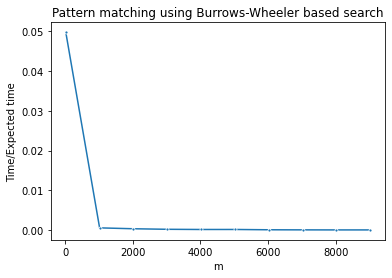

In [49]:
h = sns.lineplot(x = 'm', y = 'Time/Expected time', marker = '.',
                    data = df_search)
h.set_title('Pattern matching using Burrows-Wheeler based search')
h.figure.savefig('figures/search_bw.pdf')

In [50]:
def time_bssearch(sa, m):
    df = pd.DataFrame(range(20, m, int(m/10)), columns=['m'])
    fastq_file = create_many_fastq(20, m, int(m/10))

    fastq = parsers.read_fastq_file(fastq_file)
    sa = parsers.read_SA_LCP(sa)
    times = []

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in sa.items():
        rname = x[0]
        y = x[1][0] + "$"
        sa = x[1][1]

        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            start = time.time()
            matches = stinesnotes.binary3(substring, y,  sa)
            end = time.time()
            difference = end - start
            times.append(difference)
            print("H")

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}")

    df['Time'] = times

    df['Time/Expected time'] = df['Time']/(df['m']*np.log10(m))

    return df,matches


In [51]:
n = 100000
m = 10000

In [52]:
df_search,matches = time_bssearch("test_files/n_100000.fa.sa-lcp", m)

H
H
H
H
H
H
H
H
H
H


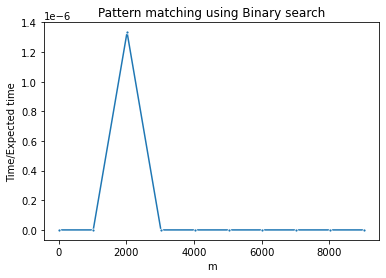

In [53]:
h = sns.lineplot(x = 'm', y = 'Time/Expected time', marker = '.',
                    data = df_search)
h.set_title('Pattern matching using Binary search')
h.figure.savefig('figures/search_bw.pdf')

In [54]:
print(df_search)
print(matches)

      m      Time  Time/Expected time
0    20  0.000000            0.000000
1  1020  0.000000            0.000000
2  2020  0.010781            0.000001
3  3020  0.000000            0.000000
4  4020  0.000000            0.000000
5  5020  0.000000            0.000000
6  6020  0.000000            0.000000
7  7020  0.000000            0.000000
8  8020  0.000000            0.000000
9  9020  0.000000            0.000000
None
